In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as py

C:\Users\HP\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
image_size = 256
batch_size = 32

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage_dataset_dl", 
    shuffle = True,
    image_size = (image_size, image_size), 
    batch_size = batch_size
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape, image_batch[0].shape)
    print(label_batch)

(32, 256, 256, 3) (256, 256, 3)
tf.Tensor([1 1 0 0 0 1 1 0 1 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 1 1 1 0 0 0], shape=(32,), dtype=int32)


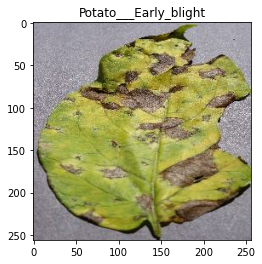

In [6]:
for image_batch, label_batch in dataset.take(1):
    py.imshow(image_batch[0].numpy().astype('uint8'))
    py.title(class_names[0])

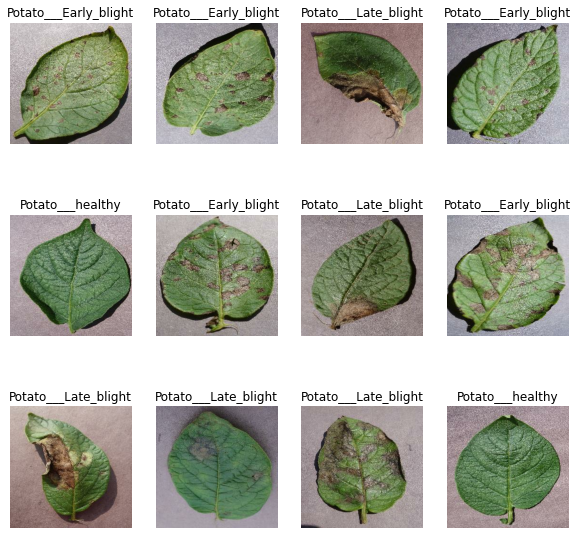

In [7]:
py.figure(figsize = (10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = py.subplot(3,4,i+1)
        py.imshow(image_batch[i].numpy().astype('uint8'))
        py.title(class_names[label_batch[i]])
        py.axis("off")

In [8]:
# splitting the dataset

print(len(dataset))
print(int(len(dataset) * 0.8))


68
54


In [9]:
train_ds = dataset.take(54)
test_ds = dataset.skip(54)
print(len(train_ds), len(test_ds))

54 14


In [10]:
val_ds = test_ds.take(6)
test_ds = test_ds.skip(6)
print(len(val_ds), len(test_ds))

6 8


In [11]:
def get_dataset_partition(ds, train_split =0.8, val_split=0.1, test_split =0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)  #seed is just to take the same number everytime
    train_size = int(ds_size * train_split)  #54
    val_size = int(ds_size * val_split)    # 6
    
    train_ds = ds.take(train_size)  #54
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    
    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = get_dataset_partition(dataset)

In [13]:
print(len(train_ds), len(val_ds), len(test_ds))

54 6 8


In [14]:
# cache is used firstly to take the img from directory and store in memory..next time when take from memory improve processing 

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

In [15]:
data_aug = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [16]:
resize_and_scale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(image_size,image_size),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [17]:
CHANNELS=3
from keras import layers

input_shape = (batch_size, image_size, image_size, CHANNELS)
n_classes = 3


model = tf.keras.Sequential([
    resize_and_scale,
    data_aug,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [19]:
model.build(input_shape=input_shape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [21]:
model.compile(
    optimizer='adam',
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=7,
)

Epoch 1/7
54/54 [==============================] - 85s 1s/step - loss: 0.9113 - accuracy: 0.4832 - val_loss: 0.8750 - val_accuracy: 0.4844
Epoch 2/7
54/54 [==============================] - 74s 1s/step - loss: 0.7839 - accuracy: 0.6319 - val_loss: 0.8792 - val_accuracy: 0.6094
Epoch 3/7
54/54 [==============================] - 72s 1s/step - loss: 0.5923 - accuracy: 0.7541 - val_loss: 0.5106 - val_accuracy: 0.7969
Epoch 4/7
54/54 [==============================] - 72s 1s/step - loss: 0.4891 - accuracy: 0.8108 - val_loss: 0.5013 - val_accuracy: 0.8177
Epoch 5/7
54/54 [==============================] - 71s 1s/step - loss: 0.4545 - accuracy: 0.8056 - val_loss: 0.3882 - val_accuracy: 0.8646
Epoch 6/7
54/54 [==============================] - 75s 1s/step - loss: 0.3501 - accuracy: 0.8507 - val_loss: 0.3223 - val_accuracy: 0.8750
Epoch 7/7
54/54 [==============================] - 72s 1s/step - loss: 0.2996 - accuracy: 0.8837 - val_loss: 0.2250 - val_accuracy: 0.9010


In [22]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 293ms/step - loss: 0.2103 - accuracy: 0.9180


First actual image to predict
actual label :  Potato___Late_blight
Predicted Img..
Predicted Label :  Potato___Late_blight


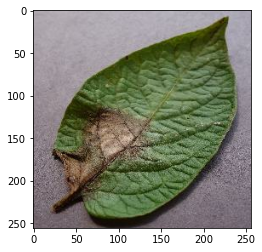

In [29]:
# prediction

import numpy as np

for images_batch, label_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    print("First actual image to predict")
    py.imshow(first_image)
    print("actual label : ", class_names[first_label])
    
    print("Predicted Img..")
    pred_res = model.predict(images_batch)
    print("Predicted Label : ", class_names[np.argmax(pred_res[0])])